# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [287]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [288]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [289]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [290]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [291]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [292]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

# !pip install -r requirements_cleaning_eda.txt
from P5_functions import *

Importation of modules and packages. 

In [293]:
import io

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import missingno as msno
import ppscore as pps

import dill

Setting pandas display options

In [294]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [295]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [296]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Data is composed of 9 distinct .csv files, that we'll load in a dictionnary of dataframes.

In [297]:
# from datetime import strptime

if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [298]:
df_orders.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_status', 'order_purchase_timestamp', 'shipping_time', 'shipping_delay', 'delivered',
       'price', 'freight_value', 'order_item_nb', 'max_limit_ship_date', 'mean_prod_descr_length',
       'review_score', 'review_comment_length', 'cum_paytype', 'paytype_boleto',
       'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined', 'paytype_voucher',
       'payment_installments', 'payment_value', 'main_prod_categ', 'cat_office', 'cat_unknown',
       'cat_fashion', 'cat_furniture', 'cat_hygiene', 'cat_home', 'cat_leisure', 'cat_diy',
       'cat_multimedia', 'cat_food', 'cat_electronics', 'cat_books', 'cat_miscellaneous'],
      dtype='object')

In [299]:
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))

df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  

df_orders['customer_zip_code_prefix'] = \
    df_orders['customer_zip_code_prefix'].astype('object')

In [300]:
df_orders.dtypes

customer_unique_id                   object
customer_zip_code_prefix             object
customer_city                        object
customer_state                       object
order_status                         object
order_purchase_timestamp     datetime64[ns]
shipping_time               timedelta64[ns]
shipping_delay              timedelta64[ns]
delivered                             int64
price                               float64
freight_value                       float64
order_item_nb                       float64
max_limit_ship_date          datetime64[ns]
mean_prod_descr_length              float64
review_score                        float64
review_comment_length               float64
cum_paytype                          object
paytype_boleto                        int64
paytype_credit_card                   int64
paytype_debit_card                    int64
paytype_not_defined                   int64
paytype_voucher                       int64
payment_installments            

In [301]:
speak('Dataset successfully imported')

## 1 Building the Customer dataset

Let's now aggregate all the orders to get a dataset of the customers.

### 1.1 Aggregation of orders to get customers dataframe

In [302]:
df_orders.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_status', 'order_purchase_timestamp', 'shipping_time', 'shipping_delay', 'delivered',
       'price', 'freight_value', 'order_item_nb', 'max_limit_ship_date', 'mean_prod_descr_length',
       'review_score', 'review_comment_length', 'cum_paytype', 'paytype_boleto',
       'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined', 'paytype_voucher',
       'payment_installments', 'payment_value', 'main_prod_categ', 'cat_office', 'cat_unknown',
       'cat_fashion', 'cat_furniture', 'cat_hygiene', 'cat_home', 'cat_leisure', 'cat_diy',
       'cat_multimedia', 'cat_food', 'cat_electronics', 'cat_books', 'cat_miscellaneous'],
      dtype='object')

In [303]:
print("Min time (purchase) in df_orders",
      df_orders.order_purchase_timestamp.min())
print("Max time (purchase) in df_orders",
      df_orders.order_purchase_timestamp.max())

Min time (purchase) in df_orders 2016-09-04 21:15:19
Max time (purchase) in df_orders 2018-10-17 17:30:18


In [304]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

df_cust = create_agg_cust_df(df_orders)

In [305]:
df_cust.columns

Index(['cust_city', 'cust_zipcode', 'cust_state', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order', 'tot_price',
       'tot_nb_ord', 'tot_nb_deliv_ord', 'mean_ship_delay', 'time_since_first_purch',
       'time_since_last_purch', 'mean_ship_time', 'mean_prod_descr_length', 'main_prod_categ',
       'mean_rev_score', 'tot_comment_length', 'mean_comment_length', 'mean_pay_value_per_order',
       'tot_pay_value', 'paytype_debit_card_tot_nb', 'cum_paytype', 'paytype_credit_card_tot_nb',
       'mean_pay_install', 'paytype_boleto_tot_nb', 'paytype_not_defined_tot_nb',
       'paytype_voucher_tot_nb', 'cat_multimedia_tot_nb', 'cat_electronics_tot_nb',
       'cat_home_tot_nb', 'cat_furniture_tot_nb', 'cat_food_tot_nb', 'cat_hygiene_tot_nb',
       'cat_leisure_tot_nb', 'cat_books_tot_nb', 'cat_diy_tot_nb', 'cat_unknown_tot_nb',
       'cat_miscellaneous_tot_nb', 'cat_office_tot_nb', 'cat_fashion_tot_nb'],
      dtype='o

### 1.2 Feature engineering

In [306]:
df_cust.shape

(96095, 42)

In [307]:
df_cust.head(3)

,cust_city,cust_zipcode,cust_state,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,tot_price,tot_nb_ord,tot_nb_deliv_ord,mean_ship_delay,time_since_first_purch,time_since_last_purch,mean_ship_time,mean_prod_descr_length,main_prod_categ,mean_rev_score,tot_comment_length,mean_comment_length,mean_pay_value_per_order,tot_pay_value,paytype_debit_card_tot_nb,cum_paytype,paytype_credit_card_tot_nb,mean_pay_install,paytype_boleto_tot_nb,paytype_not_defined_tot_nb,paytype_voucher_tot_nb,cat_multimedia_tot_nb,cat_electronics_tot_nb,cat_home_tot_nb,cat_furniture_tot_nb,cat_food_tot_nb,cat_hygiene_tot_nb,cat_leisure_tot_nb,cat_books_tot_nb,cat_diy_tot_nb,cat_unknown_tot_nb,cat_miscellaneous_tot_nb,cat_office_tot_nb,cat_fashion_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,7787,SP,1.00,1.00,12.00,12.00,129.90,129.90,1,1,6 days 09:52:10,160 days 06:33:51,160 days 06:33:51,6 days 09:52:10,236.00,bed_bath_table,5.00,111.00,111.00,141.90,141.90,0,C,1,8.00,0,0,0,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,6053,SP,1.00,1.00,8.29,8.29,18.90,18.90,1,1,3 days 06:51:15,163 days 06:18:51,163 days 06:18:51,3 days 06:51:15,635.00,health_beauty,4.00,0.00,0.00,27.19,27.19,0,C,1,1.00,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000f46a3911fa3c0805444483337064,sao jose,88115,SC,1.00,1.00,17.22,17.22,69.00,69.00,1,1,25 days 17:33:44,585 days 20:25:15,585 days 20:25:15,25 days 17:33:44,177.00,stationery,3.00,0.00,0.00,86.22,86.22,0,C,1,8.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


#### Format conversion of timedeltas

In [308]:
# time_cols = df_cust.select_dtypes(include=['timedelta64[ns]']).columns
# print(time_cols)
# for c in time_cols:
#     df_cust[c] = df_cust[c].apply(lambda x: x.days)

#### Single purchase

In [309]:
# ser = (df_cust['tot_nb_ord']==1).map({True: 1, False: 0})
# df_cust.insert(loc=11, column='single_purch', value=ser)

#### Total nb of not-received orders

In [310]:
# ser = (df_cust['tot_nb_ord']-df_cust['tot_nb_deliv_ord'])
# df_cust.insert(loc=12, column='nb_not_rec_orders', value=ser)

#### Average freight/payment value ratio

In [311]:
# ser = df_cust['tot_freight_val']/df_cust['tot_pay_value']
# df_cust.insert(loc=8, column='avg_freight_payval_ratio', value=ser.fillna(0))

### Function that encapsulates the feature engineering

In [312]:
def create_features_cust_df(df_cust):
    df_cust_mod = df_cust.copy('deep')
    # conversion of timedeltas
    time_cols = df_cust_mod.select_dtypes(include=['timedelta64[ns]']).columns
    for c in time_cols:
        df_cust_mod[c] = df_cust_mod[c].apply(lambda x: x.days)

    # Single purchase
    ser = (df_cust_mod['tot_nb_ord']==1).map({True: 1, False: 0})
    df_cust_mod.insert(loc=11, column='single_purch', value=ser)

    # Total number of not received orders
    ser = (df_cust_mod['tot_nb_ord']-df_cust_mod['tot_nb_deliv_ord'])
    df_cust_mod.insert(loc=12, column='nb_not_rec_orders', value=ser)

    # Average freight on payment value ratio
    ser = df_cust_mod['tot_freight_val']/df_cust_mod['tot_pay_value']
    df_cust_mod.insert(loc=8, column='avg_freight_payval_ratio', value=ser.fillna(0))
    return df_cust_mod

In [313]:
df_cust = create_features_cust_df(df_cust)

## 2 Data exploration

In [314]:
df_cust.shape

(96095, 45)

#### Describe

In [315]:
df_cust.describe(include='all')

,cust_city,cust_zipcode,cust_state,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,avg_freight_payval_ratio,tot_price,tot_nb_ord,tot_nb_deliv_ord,single_purch,nb_not_rec_orders,mean_ship_delay,time_since_first_purch,time_since_last_purch,mean_ship_time,mean_prod_descr_length,main_prod_categ,mean_rev_score,tot_comment_length,mean_comment_length,mean_pay_value_per_order,tot_pay_value,paytype_debit_card_tot_nb,cum_paytype,paytype_credit_card_tot_nb,mean_pay_install,paytype_boleto_tot_nb,paytype_not_defined_tot_nb,paytype_voucher_tot_nb,cat_multimedia_tot_nb,cat_electronics_tot_nb,cat_home_tot_nb,cat_furniture_tot_nb,cat_food_tot_nb,cat_hygiene_tot_nb,cat_leisure_tot_nb,cat_books_tot_nb,cat_diy_tot_nb,cat_unknown_tot_nb,cat_miscellaneous_tot_nb,cat_office_tot_nb,cat_fashion_tot_nb
count,96095,96095.00,96095,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00,96095.00
unique,4119,14981.00,27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,74,nan,nan,nan,nan,nan,nan,7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,sao paulo,22790.00,SP,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,bed_bath_table,nan,nan,nan,nan,nan,nan,C,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,14977,136.00,40301,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8707,nan,nan,nan,nan,nan,nan,71774,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,nan,NaN,1.13,1.17,22.65,23.43,137.16,0.21,141.44,1.03,1.00,0.97,0.03,11.74,290.45,287.73,11.74,778.55,NaN,4.06,30.13,29.26,161.40,166.59,0.02,NaN,0.80,2.97,0.21,0.00,0.16,0.00,0.26,0.32,0.23,0.01,0.17,0.25,0.01,0.07,0.02,0.09,0.05,0.03
std,NaN,nan,NaN,0.53,0.63,21.56,22.88,210.74,0.13,217.22,0.21,0.27,0.17,0.17,9.63,153.90,153.41,9.63,653.24,NaN,1.36,50.85,49.23,222.31,231.43,0.13,NaN,0.49,2.72,0.42,0.01,2.94,0.07,0.54,0.65,0.59,0.14,0.44,0.52,0.10,0.34,0.15,0.34,0.26,0.19
min,NaN,nan,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.33,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,nan,NaN,1.00,1.00,13.75,13.92,45.83,0.11,45.99,1.00,1.00,1.00,0.00,6.00,166.00,163.00,6.00,341.00,NaN,4.00,0.00,0.00,62.46,63.12,0.00,NaN,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,nan,NaN,1.00,1.00,17.16,17.53,85.99,0.18,89.00,1.00,1.00,1.00,0.00,10.00,272.00,268.00,10.00,599.00,NaN,5.00,0.00,0.00,105.83,108.00,0.00,NaN,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,nan,NaN,1.00,1.00,23.99,25.42,149.90,0.27,154.00,1.00,1.00,1.00,0.00,15.00,400.00,397.00,15.00,985.00,NaN,5.00,44.00,43.00,177.21,183.53,0.00,NaN,1.00,4.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [316]:
df_cust.dtypes.value_counts()

float64    27
int64      13
object      5
dtype: int64

### 2.1 Quantitative data

In [317]:
Q_cols = df_cust.select_dtypes(include=[np.number]).columns
Q_cols

Index(['mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order', 'tot_freight_val',
       'mean_price_per_order', 'avg_freight_payval_ratio', 'tot_price', 'tot_nb_ord',
       'tot_nb_deliv_ord', 'single_purch', 'nb_not_rec_orders', 'mean_ship_delay',
       'time_since_first_purch', 'time_since_last_purch', 'mean_ship_time',
       'mean_prod_descr_length', 'mean_rev_score', 'tot_comment_length', 'mean_comment_length',
       'mean_pay_value_per_order', 'tot_pay_value', 'paytype_debit_card_tot_nb',
       'paytype_credit_card_tot_nb', 'mean_pay_install', 'paytype_boleto_tot_nb',
       'paytype_not_defined_tot_nb', 'paytype_voucher_tot_nb', 'cat_multimedia_tot_nb',
       'cat_electronics_tot_nb', 'cat_home_tot_nb', 'cat_furniture_tot_nb', 'cat_food_tot_nb',
       'cat_hygiene_tot_nb', 'cat_leisure_tot_nb', 'cat_books_tot_nb', 'cat_diy_tot_nb',
       'cat_unknown_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_office_tot_nb',
       'cat_fashion_tot_nb'],
      dtype='object

In [318]:
len(Q_cols)

40

#### Boxplots

independant features

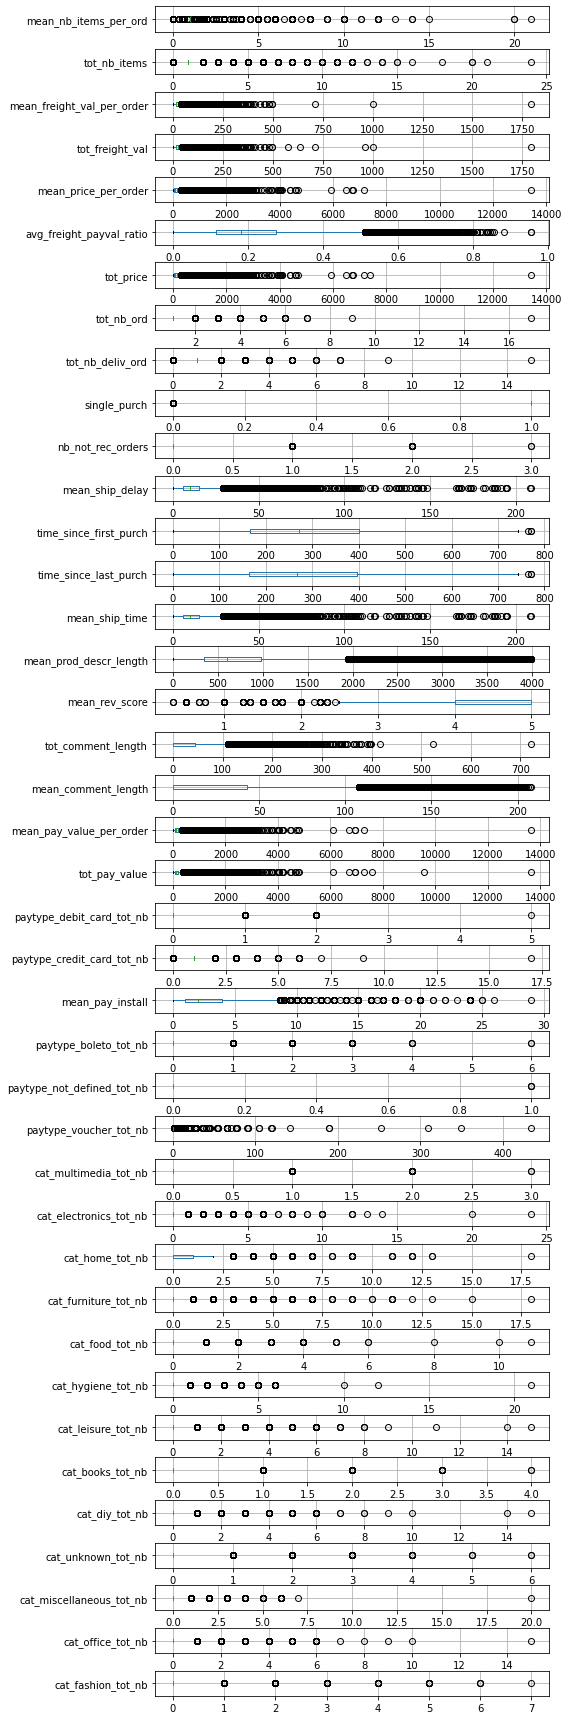

In [319]:
fig, axs = plt.subplots(len(df_cust[Q_cols].columns),1,
                        figsize=(8, 24), sharey=False)
for c, ax in zip(df_cust[Q_cols].columns, axs):
    df_cust.boxplot(c, vert=False, ax=ax)
fig.tight_layout(h_pad=0.051)
plt.show()

#### Histograms

Plotting histograms of the main quantitative continuous columns.

* Histograms of independant features

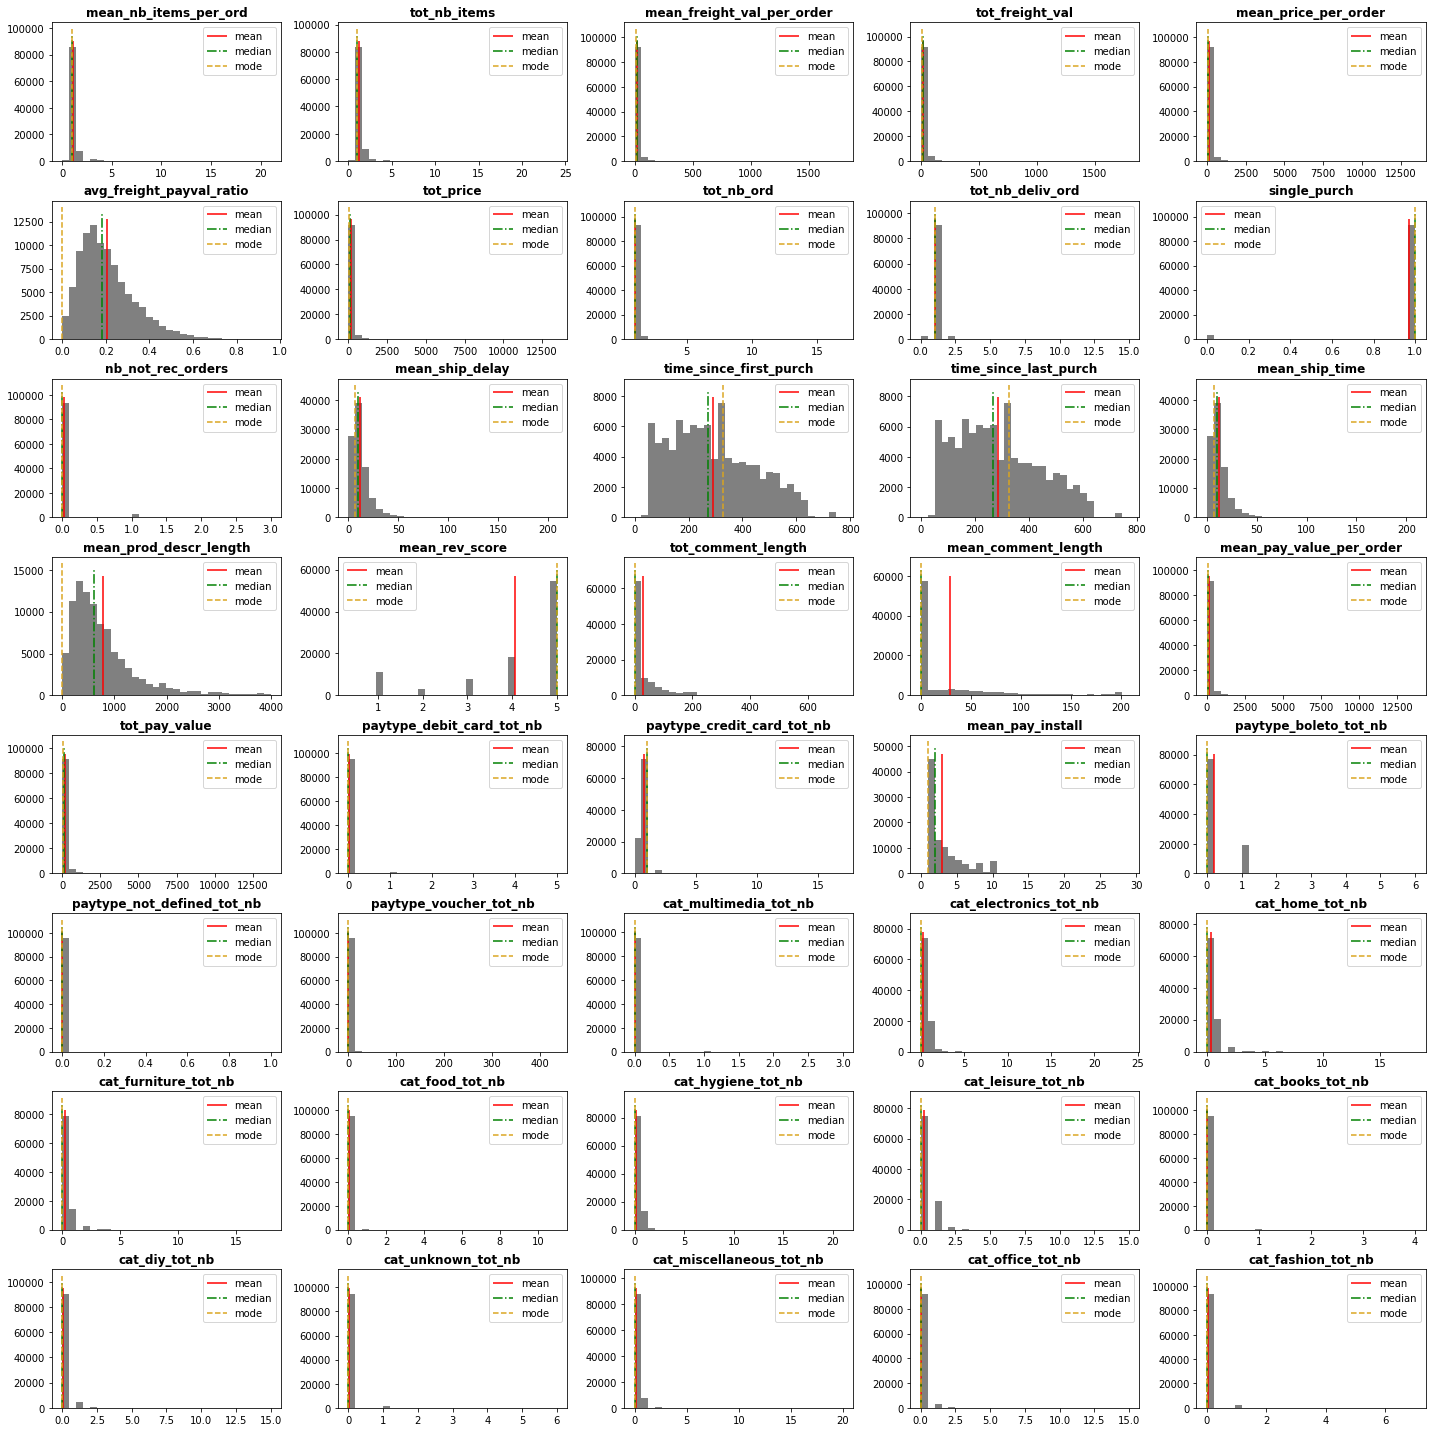

In [320]:
# All the data (with outliers)
plot_histograms(df=df_cust, cols=Q_cols,
                figsize=(20,20), bins=30, layout=(8,5), skip_outliers=False,
                thresh=3, save_enabled=False)

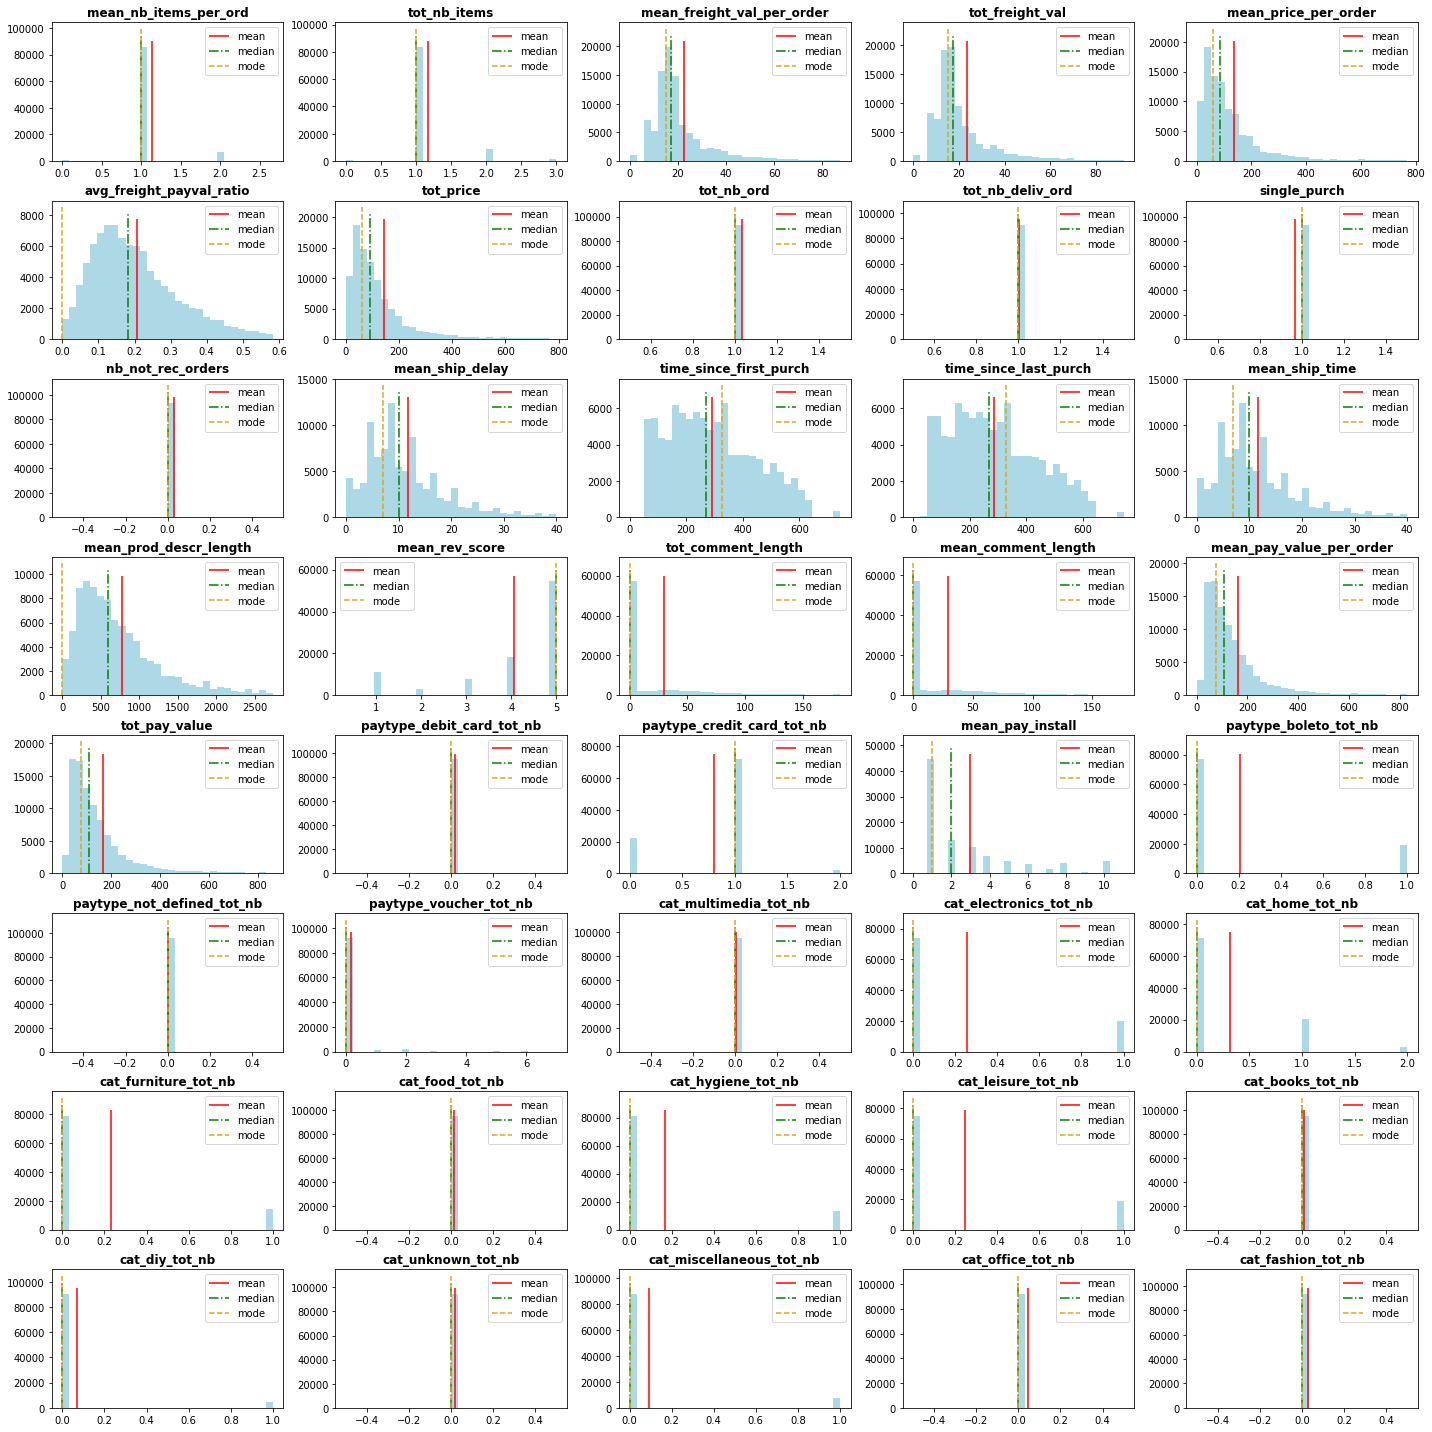

In [321]:
# Excluding outliers to get a better scale
plot_histograms(df=df_cust, cols=Q_cols, color = 'lightblue',
                figsize=(20,20), bins=30, layout=(8,5), skip_outliers=True,
                thresh=3, save_enabled=False)

#### Correlations

Linear correlation (Pearson)

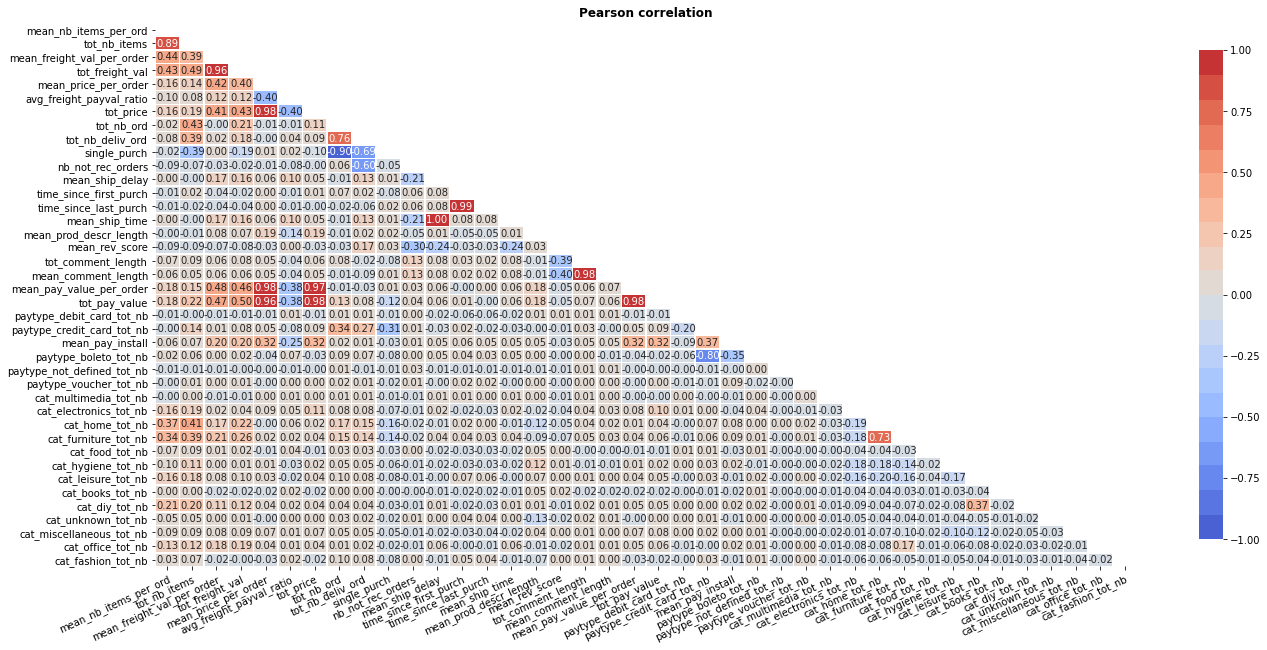

In [322]:
pears_corr = df_cust[Q_cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(22,10))
plt.show()

#### PCA

In [323]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.set_printoptions(formatter={'float': '{: 6.2f}'.format})

pca_cols = [c for c in Q_cols if not (('cat_' in c) or ('paytype' in c))]
print("columns used for the PCA: ", pca_cols)

df_pca = df_cust.loc[:, pca_cols].dropna(how='any')
id_code = df_pca.index
X = df_pca.values

X_sc = StandardScaler().fit_transform(X)

n_comp = 10
pca = PCA(n_components=n_comp).fit(X_sc)

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T

X_proj = pca.transform(X_sc)

columns used for the PCA:  ['mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order', 'avg_freight_payval_ratio', 'tot_price', 'tot_nb_ord', 'tot_nb_deliv_ord', 'single_purch', 'nb_not_rec_orders', 'mean_ship_delay', 'time_since_first_purch', 'time_since_last_purch', 'mean_ship_time', 'mean_prod_descr_length', 'mean_rev_score', 'tot_comment_length', 'mean_comment_length', 'mean_pay_value_per_order', 'tot_pay_value', 'mean_pay_install']


Plotting principal components

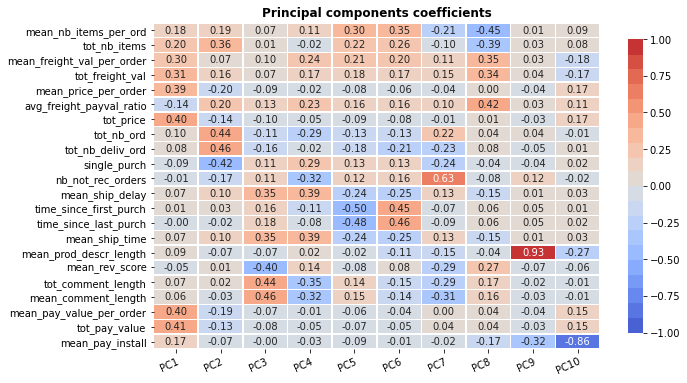

In [324]:
plot_heatmap(pca_df,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(10,6),shape='rect')
plt.show()

Plotting explained variance ratio in scree plot

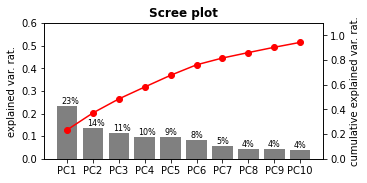

In [325]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_df.columns, exp_var_rat=exp_var_rat,
           ylim=(0,0.6), figsize=(5,2.5))
plt.show()

First 6 principal components explain 75% of the variance of the data.
We may try to use the principal components later for our model.

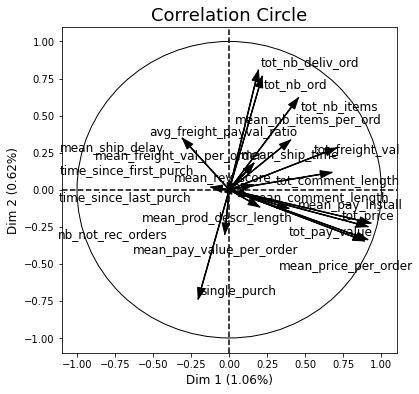

In [326]:
from mlxtend.plotting import plot_pca_correlation_graph # !pip install mlxtend==0.17.3

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(1, 2), figure_axis_size=6,
                                X_pca = X_proj[:,0:2],
                                explained_variance = exp_var_rat[0:2])
plt.show()

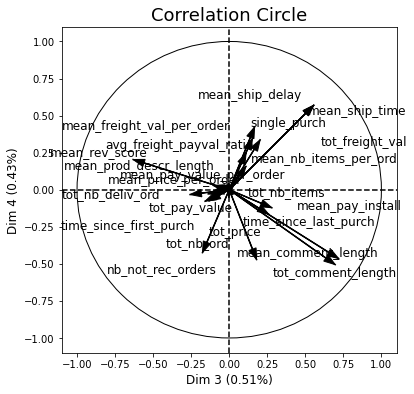

In [327]:
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(3, 4), figure_axis_size=6,
                                X_pca = X_proj[:,0:4],
                                explained_variance = exp_var_rat[0:4])
plt.show()

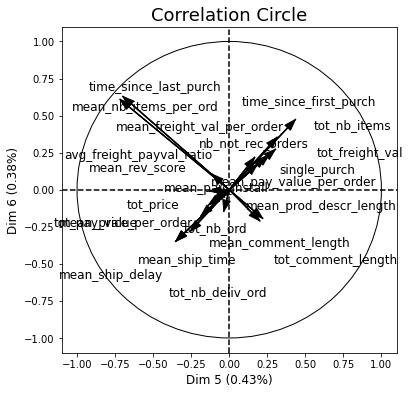

In [328]:
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(5, 6), figure_axis_size=6,
                                X_pca = X_proj[:,0:6],
                                explained_variance = exp_var_rat[0:6])
plt.show()

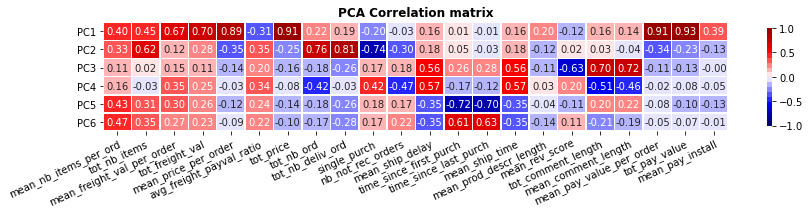

In [329]:
plot_heatmap(correlation_matrix.T,'PCA Correlation matrix',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("seismic", 20),
             figsize=(14,2),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
plt.show()

### 2.2 Categorical data

In [330]:
C_cols = df_cust.select_dtypes(include=['object']).columns
C_cols

Index(['cust_city', 'cust_zipcode', 'cust_state', 'main_prod_categ', 'cum_paytype'], dtype='object')

#### Bar plots

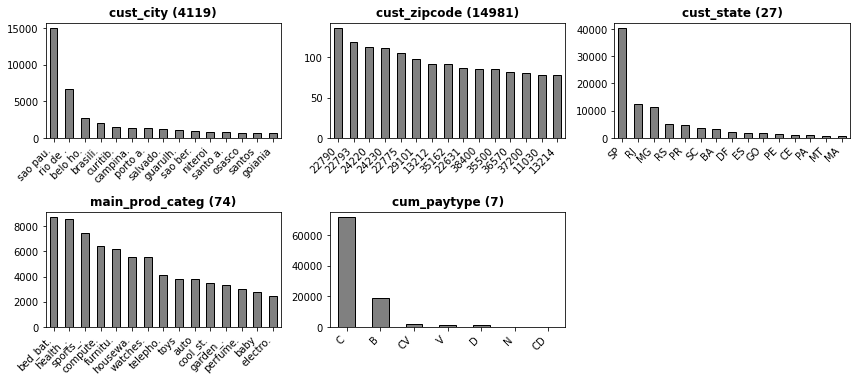

In [331]:
plot_barplots(df=df_cust, cols=C_cols, figsize=(12,10), layout=(4,3))
plt.show()

#### Predictive Power Score

Predictive Power Score on main features (ppscore)

In [332]:
# df_cust.columns

In [333]:
# pps_corr.isna().sum()

In [334]:
# plot_heatmap(pps_corr.dropna(), title="Predictive Power Score", 
#              vmin=0, center=0.5, vmax=1, figsize=(12,7), shape='rect',
#              palette=sns.color_palette("Oranges", 10))
# plt.show()

In [335]:
speak("data exploration: done")

## 3 Exportation of the Customers dataset

Now we export the dataset of aggregated orders in a .csv file.

In [336]:
df_cust.head()

,cust_city,cust_zipcode,cust_state,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,avg_freight_payval_ratio,tot_price,tot_nb_ord,tot_nb_deliv_ord,single_purch,nb_not_rec_orders,mean_ship_delay,time_since_first_purch,time_since_last_purch,mean_ship_time,mean_prod_descr_length,main_prod_categ,mean_rev_score,tot_comment_length,mean_comment_length,mean_pay_value_per_order,tot_pay_value,paytype_debit_card_tot_nb,cum_paytype,paytype_credit_card_tot_nb,mean_pay_install,paytype_boleto_tot_nb,paytype_not_defined_tot_nb,paytype_voucher_tot_nb,cat_multimedia_tot_nb,cat_electronics_tot_nb,cat_home_tot_nb,cat_furniture_tot_nb,cat_food_tot_nb,cat_hygiene_tot_nb,cat_leisure_tot_nb,cat_books_tot_nb,cat_diy_tot_nb,cat_unknown_tot_nb,cat_miscellaneous_tot_nb,cat_office_tot_nb,cat_fashion_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,7787,SP,1.00,1.00,12.00,12.00,129.90,0.08,129.90,1,1,1,0,6,160,160,6,236.00,bed_bath_table,5.00,111.00,111.00,141.90,141.90,0,C,1,8.00,0,0,0,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,6053,SP,1.00,1.00,8.29,8.29,18.90,0.30,18.90,1,1,1,0,3,163,163,3,635.00,health_beauty,4.00,0.00,0.00,27.19,27.19,0,C,1,1.00,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000f46a3911fa3c0805444483337064,sao jose,88115,SC,1.00,1.00,17.22,17.22,69.00,0.20,69.00,1,1,1,0,25,585,585,25,177.00,stationery,3.00,0.00,0.00,86.22,86.22,0,C,1,8.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
0000f6ccb0745a6a4b88665a16c9f078,belem,66812,PA,1.00,1.00,17.63,17.63,25.99,0.40,25.99,1,1,1,0,20,369,369,20,1741.00,telephony,4.00,12.00,12.00,43.62,43.62,0,C,1,4.00,0,0,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0004aac84e0df4da2b147fca70cf8255,sorocaba,18040,SP,1.00,1.00,16.89,16.89,180.00,0.09,180.00,1,1,1,0,13,336,336,13,794.00,telephony,5.00,0.00,0.00,196.89,196.89,0,C,1,6.00,0,0,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [337]:
df_cust.reset_index().to_csv('agg_customers.csv')

In [ ]:
speak('exportation of cleaned data: done')